# 1. Combining `xcdat` with `xsearch` to perform multimodel analysis

## Goals

2. Outline setup of [`xsearch`](https://github.com/pochedls/xsearch) and [`xcdat`](https://xcdat.readthedocs.io/en/latest/)
3. Demonstrate xsearch CMIP search utility
    * Search for data
    * Get models included in search
    * Show dataset metadata

# Goals continued

4. Demonstrate common uses of xcdat
    * Load data
    * Subset to satellite time period (1979 - 2014)
    * Regrid models to common grid
    * Compute annual average values and monthly anomalies
    * Compute and plot global mean temperature values
    * Compute warming trend over each grid cell
5. Combine xsearch and xcdat
    * Compute EOF across CMIP6 warming maps
    * Show that PC scales with equilibrium climate sensitivity (similar to Tokarska et al. 2020)

# 2. Setup of xcdat and xsearch

1. Produce vanilla `"xcdat"` environment using conda:

    ```console
    conda create -n xcdat -c conda-forge xcdat xesmf
    conda activate xcdat
    ```
    
Note that this environment uses additional packages: `conda create -n xcdat -c conda-forge xcdat xesmf ipykernel ipython jupyter matplotlib cartopy scikit-learn nc-time-axis`

2. Download and install `xsearch` into the `"xcdat"` conda environment:

    - Directly from GitHub
        ```console
        git clone https://github.com/pochedls/xsearch.git
        cd xsearch
        python -m pip install .
        ```

  - Alternatively, we maintain a version that can be added to your `PYTHONPATH`. To do this, add the following to your `.bashrc` or `.bash_profile`:

        ```console
        export PYTHONPATH="$PYTHONPATH:/p/user_pub/xclim/persist/software/xcdat/"
export JUPYTER_PATH="$JUPYTER_PATH:/p/user_pub/xclim/persist/software/xcdat/"
        ```

Note that on LC machines, the path includes `/climate/`: `/p/climate/user_pub/xclim/persist/software/xcdat/`


3. \<OPTIONAL\> Enable `xsearch` in Jupyter, run:

    ```console
    python -m ipykernel install --user --name xcdat --display-name xcdat
    ```

# 3. Using xsearch

[`xsearch`](https://github.com/pochedls/xsearch) :: a utility which allows PCMDI users to query CMIP5 and CMIP6 data. The utility returns dataset paths for a given search criteria.

In [1]:
import xsearch as xs  # import the xsearch library

In [2]:
dpaths = xs.findPaths('historical', 'tas', 'mon', mip_era='CMIP6')  # perform simple search

Multiple values for cmipTable. Consider filtering by cmipTable.
Available values: Amon, ImonGre, ImonAnt

Multiple values for realm. Consider filtering by realm.
Available values: atmos, landIce



In [3]:
dpaths = xs.findPaths("historical", "tas", "mon", mip_era="CMIP6", cmipTable="Amon", realm="atmos")

In [4]:
print('Number of datasets: ' + str(len(dpaths.keys())))

Number of datasets: 676


Note that you can also filter by: `activity`, `institute`, `model`, `member`, `grid`, or `gridLabel`. For LC machines, add `lcpath=True`.

`dpaths` is a dictionary that contains metadata for a number of dataset paths (the keys). 

![dpaths_schema](images/dpath_schema.png)

In [5]:
# Get the first path and print it.
first_path = list(dpaths.keys())[0]
print(first_path)

/p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-1/historical/r1i1p1f1/Amon/tas/gr/v20191211/


In [6]:
# print metadata keys associated with dataset path
print(dpaths[first_path].keys())

dict_keys(['keyid', 'mip_era', 'activity', 'institute', 'model', 'experiment', 'member', 'cmipTable', 'realm', 'frequency', 'variable', 'grid', 'gridLabel', 'version', 'timepoints', 'nfiles', 'nc_creation_date', 'sumfilesize_bytes', 'has_zero_size_files', 'created', 'modified', 'accessed', 'retired', 'retire_datetime', 'retracted', 'retracted_datetime', 'ignored', 'ignored_datetime', 'comment', 'unique', 'alternate_paths'])


Example: show the number of files associated with the dataset

In [7]:
dpaths[first_path]['nfiles']

17

In [8]:
# Print the metadata for the first path.
for key in dpaths[first_path].keys():
    print(key + ': ' + str(dpaths[first_path][key]))

keyid: CMIP6.CMIP.E3SM-Project.E3SM-1-1.historical.r1i1p1f1.Amon.atmos.mon.tas.gr.glb-z1-gr.v20191211
mip_era: CMIP6
activity: CMIP
institute: E3SM-Project
model: E3SM-1-1
experiment: historical
member: r1i1p1f1
cmipTable: Amon
realm: atmos
frequency: mon
variable: tas
grid: gr
gridLabel: glb-z1-gr
version: v20191211
timepoints: 120
nfiles: 17
nc_creation_date: 20191211
sumfilesize_bytes: 381258003
has_zero_size_files: 0
created: 2021-04-23 20:12:34
modified: 2021-04-23 20:12:34
accessed: 2022-10-04 15:22:40
retired: 0
retire_datetime: None
retracted: 0
retracted_datetime: None
ignored: 0
ignored_datetime: None
comment: None
unique: True
alternate_paths: ['/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/historical/r1i1p1f1/Amon/tas/gr/v20191211/']


In [9]:
# find all models contained in dpaths
models = xs.getGroupValues(dpaths, 'model')
models.sort()

# print models
for model in models[0:10]:
    print(model)
print('...')

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
CESM2
CESM2-FV2
...


In [10]:
print('Number of models: ' + str(len(models)))

Number of models: 64


In [11]:
# find all datasets associated with a particular facet
e3sm_dpaths = xs.getValuesForFacet(dpaths, 'model', 'E3SM-2-0')

# print dataset paths
for dpath in e3sm_dpaths:
    print(dpath)

/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r1i1p1f1/Amon/tas/gr/v20220830/
/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r2i1p1f1/Amon/tas/gr/v20220831/
/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r3i1p1f1/Amon/tas/gr/v20220831/
/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r4i1p1f1/Amon/tas/gr/v20220901/
/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-2-0/historical/r5i1p1f1/Amon/tas/gr/v20220902/


# 4. Using xcdat

[`xcdat`](https://xcdat.readthedocs.io/en/latest/) :: an extension of xarray for climate data analysis on structured grids.

Start by loading and subsetting one dataset

In [12]:
import xcdat as xc  # import xcdat

In [13]:
model = 'E3SM-1-0'  # define model of interest
model_dataset = xs.getValuesForFacet(dpaths, 'model', model)[0]  # get first model path

In [14]:
ds = xc.open_mfdataset(model_dataset + '*.nc')  # open dataset

In [15]:
ds_subset = ds.sel(time=slice("1979-01-01", "2014-12-30"))  # subset to satellite era

Compute the annual average values and anomalies. Then compute spatial averages.

In [16]:
ds_subset_ann = ds_subset.temporal.group_average("tas", freq="year", weighted=True)  # compute annual average

In [17]:
ds_subset_anom = ds_subset.temporal.departures("tas", freq="month") # compute the monthly anomalies

/home/pochedley1/bin/anaconda3/envs/xcdat/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 36 times more chunks
  return self.array[key]


In [18]:
ts_ann_global = ds_subset_ann.spatial.average("tas").tas  # global average time series
ts_anom_global = ds_subset_anom.spatial.average("tas").tas + ts_ann_global.mean('time')  # global average time series

Sanity check: Check trend and plot time series

In [19]:
import numpy as np  # numpy for numerical calculations
import matplotlib.pyplot as plt  # matplotlib for plots

In [20]:
time_ann = np.arange(1979.5, 2015)  # time vector
gt, _ = np.polyfit(time_ann, ts_ann_global, 1)  # get trend
gt *= 10  # to K/decade units
print("The trend is: " +  '{0:.2f}'.format(np.round(gt,2)) + " K/decade")

The trend is: 0.30 K/decade


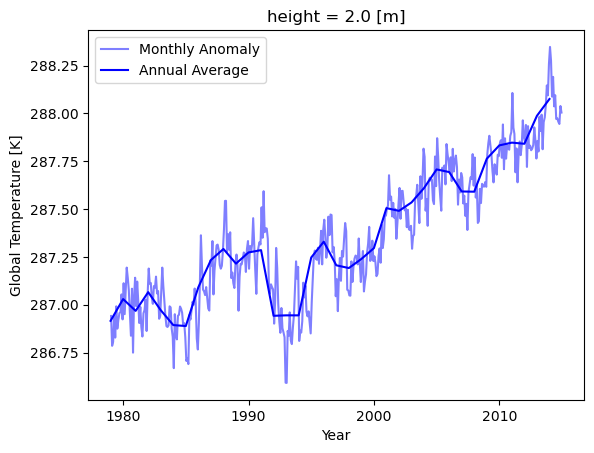

In [21]:
# plot time series
ts_anom_global.plot(color='blue', alpha=0.5, label="Monthly Anomaly")
ts_ann_global.plot(color='blue', label="Annual Average")
plt.xlabel("Year")
plt.ylabel("Global Temperature [K]")
plt.legend()

Regrid data to a 2.5$^{\circ}$ x 2.5$^{\circ}$ grid and compute the trend map.

In [22]:
# define target 2.5 x 2.5 degree grid
nlat = np.arange(-88.75, 90, 2.5)
nlon = np.arange(1.25, 360, 2.5)
target_grid = xc.create_grid(nlat, nlon)

In [23]:
# execute regrid
ds_regrid = ds_subset_ann.regridder.horizontal("tas", target_grid, tool="xesmf", method="bilinear")

In [24]:
tas = np.reshape(np.array(ds_regrid.tas), (len(time_ann), -1))  # reshape into [time, space]
trend_xy, _ = np.polyfit(time_ann, tas, 1)  # compute linear trend
trend_xy = np.reshape(trend_xy, (len(nlat), len(nlon)))  # reshape into [lat, lon]
trend_xy = trend_xy * 10  # units to K/decade

Sanity check: Plot the trend map.

In [25]:
import cartopy.crs as ccrs  # cartopy for plotting maps

Text(0.8, 0.24, '[K decade$^{-1}$]')

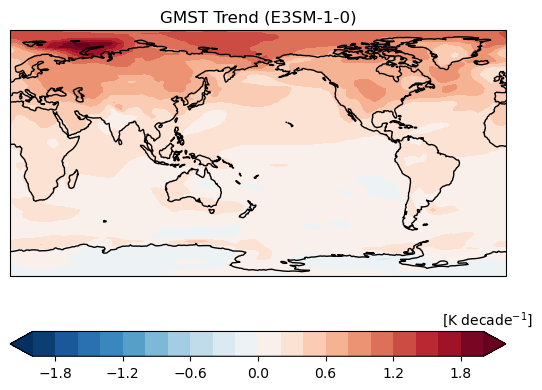

In [26]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
im = ax.contourf(nlon, nlat, trend_xy, transform=ccrs.PlateCarree(), levels=np.arange(-2.0, 2.1, 0.2), cmap=plt.cm.RdBu_r, extend="both",)
ax.coastlines()
plt.colorbar(im, orientation="horizontal")
plt.title("GMST Trend (" + model + ")")
fig = plt.gcf()
fig.text(0.8, 0.24, "[K decade$^{-1}$]")

# 5. Putting it all together

Define a convenience function to compute the trend map and global mean trend value for each model.

In [27]:
def get_model_trends(model):
    """ gt, trend_map = get_model_trends(model)
    Get global mean (gt) and trend pattern (trend_map) for
    a given model.
    """
    # get / load data
    model_dataset = xs.getValuesForFacet(dpaths, 'model', model)[0]  # get first model directory
    ds = xc.open_mfdataset(model_dataset + '*.nc')  # open dataset
    # subset and take annual average
    ds_subset = ds.sel(time=slice("1979-01-01", "2014-12-30"))  # subset
    ds_subset_aa = ds_subset.temporal.group_average("tas", freq="year", weighted=True)  # annual average
    # compute global average time series & trend
    tsg = ds_subset_aa.spatial.average("tas").tas  # global average series
    gt, _ = np.polyfit(time_ann, tsg, 1)  # get trend
    gt *= 10  # to K/decade units
    # regrid to common grid
    ds_regrid = ds_subset_aa.regridder.horizontal('tas', target_grid, tool='xesmf', method='bilinear')
    # compute trend pattern
    trend_xy, _ = np.polyfit(time_ann, np.reshape(np.array(ds_regrid.tas), (len(time_ann), -1)), 1)
    trend_map = np.reshape(trend_xy, (len(nlat), len(nlon)))
    return gt, trend_map

Slight tangent: Get ECS data...

In [28]:
import json  # read json file with ECS data
from urllib.request import urlopen  # urllib to download json file directly

In [29]:
ecs_url = "https://raw.githubusercontent.com/mzelinka/cmip56_forcing_feedback_ecs/master/cmip56_forcing_feedback_ecs.json"

# load remote ECS dataset
ecsjson = json.loads(urlopen(ecs_url).read())

ecsDict = {}
for model in ecsjson['CMIP6'].keys():
    members = list(ecsjson['CMIP6'][model].keys())
    if len(members) > 1:
        member = [m for m in members if 'r1i1p1' in m][0]
    else:
        member = members[0]
    e = ecsjson['CMIP6'][model][member]['ECS']
    ecsDict[model] = e

Loop over each model and compute trends

In [30]:
import datetime  # for timing

In [31]:
# initialize dictionaries to store trend values
trend_maps = {}
global_trends = {}

In [32]:
print(datetime.datetime.now())
# loop over all models with ECS data
models = [model for model in models if model in ecsDict.keys()]
for model in models:
    # get trends using convenience function
    gt, trend_map = get_model_trends(model)
    # store values
    global_trends[model] = gt
    trend_maps[model] = trend_map
print(datetime.datetime.now())

2023-01-19 17:47:40.681239


/home/pochedley1/bin/anaconda3/envs/xcdat/lib/python3.10/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/pochedley1/bin/anaconda3/envs/xcdat/lib/python3.10/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/pochedley1/bin/anaconda3/envs/xcdat/lib/python3.10/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/pochedley1/bin/anaconda3/envs/xcdat/lib/python3.10/site-packages/xarray/conventions.py:522: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


2023-01-19 17:50:54.056794


Now lets compute the intermodel EOF of the trend maps. 

In [33]:
# put trends / ecs values into arrays
trend_maps_array = np.array([trend_maps[model] for model in trend_maps.keys()])  # [model, lat, lon]
global_trend_array = np.array([global_trends[model] for model in trend_maps.keys()])  # [model]
ecs_array = np.array([ecsDict[model] for model in trend_maps.keys()])  # [model]

In [34]:
from sklearn.decomposition import PCA

In [35]:
# Get array shape, reshape into (samples, features), and standardize
shp = trend_maps_array.shape
X = np.reshape(trend_maps_array, (shp[0], shp[1] * shp[2]))
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)  # standardize

# Perform PCA
skpca = PCA()
skpca.fit(X)

# Collect eofs and pcs
eofs = skpca.components_
pcs = skpca.transform(X)

Show Leading EOF

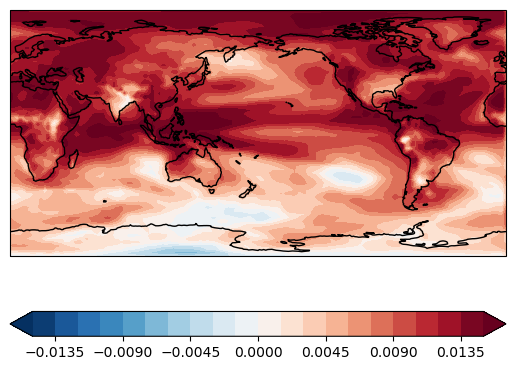

In [36]:
eof1 = np.reshape(eofs[0, :], (shp[1], shp[2]))
# plot map
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
im = ax.contourf(
    nlon,
    nlat,
    eof1,
    transform=ccrs.PlateCarree(),
    levels=np.arange(-0.015, 0.016, 0.0015),
    cmap=plt.cm.RdBu_r,
    extend="both",
)
ax.coastlines()
plt.colorbar(im, orientation="horizontal")

Compare GMST change and PC1 to ECS

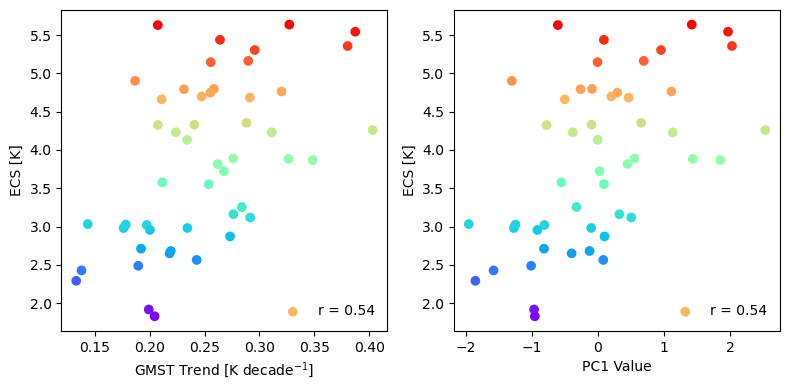

In [37]:
fig=plt.figure(figsize=(8, 4))
# Plot GSMT Trend versus ECS
plt.subplot(1, 2, 1)
r = np.corrcoef(global_trend_array, ecs_array)[0, 1]
rstring = "r = " + "{0:.2f}".format(np.round(r, 2))
plt.scatter(global_trend_array, ecs_array, c=ecs_array, label=rstring, cmap=plt.cm.rainbow)
plt.xlabel("GMST Trend [K decade$^{-1}$]"); plt.ylabel("ECS [K]")
plt.legend(frameon=False)
# Plot PC1 Value versus ECS
plt.subplot(1, 2, 2)
pc1 = pcs[:, 0]
r = np.corrcoef(pc1, ecs_array)[0, 1]
rstring = "r = " + "{0:.2f}".format(np.round(r, 2))
plt.scatter(pc1 / np.std(pc1), ecs_array, c=ecs_array, label=rstring, cmap=plt.cm.rainbow)
plt.xlabel("PC1 Value"); plt.ylabel("ECS [K]")
plt.legend(frameon=False)
plt.tight_layout()

Key code differences between CDAT and xCDAT...

![CDAT-xCDAT Differences](images/diff1.png)

![CDAT-xCDAT Differences part II](images/diff2.png)

## Key Takeaways

- [`xsearch`](https://github.com/pochedls/xsearch) is a utility that allows us to quickly query CMIP data and metadata.
- [`xcdat`](https://github.com/xCDAT/xcdat), [`xarray`](https://docs.xarray.dev/en/stable/), and other scientific and graphical packages can be combined with xsearch to perform multimodel analysis with relative ease.